Problem Statement:

Given a dataset of 426K used cars, identify the key factors that influence the price of a used car. Provide actionable recommendations to a used car dealership on what consumers value in a used car to help them make informed decisions about their inventory and pricing strategies.

In [75]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
import category_encoders as ce
import numpy as np
import plotly.express as px
import pandas as pd
import warnings

In [76]:
# Load the dataset into a pandas dataframe:
cars = pd.read_csv('/Users/aalladin/Documents/usedCarPredict/data/vehicles.csv', index_col = 0)

# Display the first few rows of the dataframe to see whats up. Lot of data quality issues:
print(cars.head())

                            region  price  year manufacturer model condition  \
id                                                                             
7222695916                prescott   6000   NaN          NaN   NaN       NaN   
7218891961            fayetteville  11900   NaN          NaN   NaN       NaN   
7221797935            florida keys  21000   NaN          NaN   NaN       NaN   
7222270760  worcester / central MA   1500   NaN          NaN   NaN       NaN   
7210384030              greensboro   4900   NaN          NaN   NaN       NaN   

           cylinders fuel  odometer title_status transmission  VIN drive size  \
id                                                                              
7222695916       NaN  NaN       NaN          NaN          NaN  NaN   NaN  NaN   
7218891961       NaN  NaN       NaN          NaN          NaN  NaN   NaN  NaN   
7221797935       NaN  NaN       NaN          NaN          NaN  NaN   NaN  NaN   
7222270760       NaN  NaN       Na

In [77]:
# identify missing data by attribute both by count and percent:
missing_data = cars.isnull().sum()
missing_percent = cars.isnull().sum() * 100 / len(cars)
missing_info = pd.DataFrame({'Missing Count': missing_data, 'Missing Percent': missing_percent})

#sort:
missing_info_sorted = missing_info.sort_values(by='Missing Count', ascending=False)
print(missing_info_sorted)

              Missing Count  Missing Percent
size                 306361        71.767476
cylinders            177678        41.622470
condition            174104        40.785232
VIN                  161042        37.725356
drive                130567        30.586347
paint_color          130203        30.501078
type                  92858        21.752717
manufacturer          17646         4.133714
title_status           8242         1.930753
model                  5277         1.236179
odometer               4400         1.030735
fuel                   3013         0.705819
transmission           2556         0.598763
year                   1205         0.282281
region                    0         0.000000
price                     0         0.000000
state                     0         0.000000


In [78]:
# Let's set a threshold for the maximum acceptable percentage of missing values: 
# Columns with a higher percentage of missing values than this threshold can be dropped:

threshold = 25
cols_to_drop = missing_info[missing_info['Missing Percent'] > threshold].index
cars_cleaned = cars.drop(columns=cols_to_drop) # creating a new dataframe with clean data:

In [79]:
cars_cleaned.head()

,region,price,year,manufacturer,model,fuel,odometer,title_status,transmission,type,state
id,,,,,,,,,,,
7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [80]:
# Identify rows that contain at least one NaN value:
nan_rows = cars_cleaned[cars_cleaned.isna().any(axis=1)]

print(f"Rows with NaN values: \n{nan_rows}")

Rows with NaN values: 
                            region  price    year manufacturer  \
id                                                               
7222695916                prescott   6000     NaN          NaN   
7218891961            fayetteville  11900     NaN          NaN   
7221797935            florida keys  21000     NaN          NaN   
7222270760  worcester / central MA   1500     NaN          NaN   
7210384030              greensboro   4900     NaN          NaN   
...                            ...    ...     ...          ...   
7302118268                 wyoming  41999  2015.0          NaN   
7301950980                 wyoming  27590  2018.0          NaN   
7301949724                 wyoming  25590  2017.0          NaN   
7301843288                 wyoming      0  2010.0       toyota   
7301592693                 wyoming  13990  2016.0          NaN   

                               model   fuel  odometer title_status  \
id                                              

In [81]:
# Drop these rows from the DataFrame:
cars_cleaned = cars_cleaned.dropna(axis=0)

# Print updated DataFrame:
print(cars_cleaned)

             region  price    year manufacturer                     model  \
id                                                                          
7316814884   auburn  33590  2014.0          gmc  sierra 1500 crew cab slt   
7316814758   auburn  22590  2010.0    chevrolet            silverado 1500   
7316814989   auburn  39590  2020.0    chevrolet       silverado 1500 crew   
7316743432   auburn  30990  2017.0       toyota      tundra double cab sr   
7316356412   auburn  15000  2013.0         ford                 f-150 xlt   
...             ...    ...     ...          ...                       ...   
7301591192  wyoming  23590  2019.0       nissan         maxima s sedan 4d   
7301591187  wyoming  30590  2020.0        volvo  s60 t5 momentum sedan 4d   
7301591147  wyoming  34990  2020.0     cadillac          xt4 sport suv 4d   
7301591140  wyoming  28990  2018.0        lexus           es 350 sedan 4d   
7301591129  wyoming  30590  2019.0          bmw  4 series 430i gran coupe   

In [82]:
# Convert 'year' column to integer:
cars_cleaned['year'] = cars_cleaned['year'].astype(int)

# Print updated DataFrame to check date column:
print(cars_cleaned)

             region  price  year manufacturer                     model  \
id                                                                        
7316814884   auburn  33590  2014          gmc  sierra 1500 crew cab slt   
7316814758   auburn  22590  2010    chevrolet            silverado 1500   
7316814989   auburn  39590  2020    chevrolet       silverado 1500 crew   
7316743432   auburn  30990  2017       toyota      tundra double cab sr   
7316356412   auburn  15000  2013         ford                 f-150 xlt   
...             ...    ...   ...          ...                       ...   
7301591192  wyoming  23590  2019       nissan         maxima s sedan 4d   
7301591187  wyoming  30590  2020        volvo  s60 t5 momentum sedan 4d   
7301591147  wyoming  34990  2020     cadillac          xt4 sport suv 4d   
7301591140  wyoming  28990  2018        lexus           es 350 sedan 4d   
7301591129  wyoming  30590  2019          bmw  4 series 430i gran coupe   

              fuel  odom

In [83]:
# Dropping irrelevant columns as they are not needed for my evaluation and recommendation:
columns_to_drop = ['title_status', 'region', 'fuel']

# Drop the columns:
cars_cleaned = cars_cleaned.drop(columns=columns_to_drop)

In [84]:
# Print updated DataFrame to check if the columns got dropped:
print(cars_cleaned)

            price  year manufacturer                     model  odometer  \
id                                                                         
7316814884  33590  2014          gmc  sierra 1500 crew cab slt   57923.0   
7316814758  22590  2010    chevrolet            silverado 1500   71229.0   
7316814989  39590  2020    chevrolet       silverado 1500 crew   19160.0   
7316743432  30990  2017       toyota      tundra double cab sr   41124.0   
7316356412  15000  2013         ford                 f-150 xlt  128000.0   
...           ...   ...          ...                       ...       ...   
7301591192  23590  2019       nissan         maxima s sedan 4d   32226.0   
7301591187  30590  2020        volvo  s60 t5 momentum sedan 4d   12029.0   
7301591147  34990  2020     cadillac          xt4 sport suv 4d    4174.0   
7301591140  28990  2018        lexus           es 350 sedan 4d   30112.0   
7301591129  30590  2019          bmw  4 series 430i gran coupe   22716.0   

           

In [85]:
# Identify duplicate rows:
duplicate_rows = cars_cleaned[cars_cleaned.duplicated()]

# Drop duplicate rows:
cars_cleaned = cars_cleaned.drop_duplicates()

# Print updated DataFrame:
print(cars_cleaned)

            price  year manufacturer                     model  odometer  \
id                                                                         
7316814884  33590  2014          gmc  sierra 1500 crew cab slt   57923.0   
7316814758  22590  2010    chevrolet            silverado 1500   71229.0   
7316814989  39590  2020    chevrolet       silverado 1500 crew   19160.0   
7316743432  30990  2017       toyota      tundra double cab sr   41124.0   
7316356412  15000  2013         ford                 f-150 xlt  128000.0   
...           ...   ...          ...                       ...       ...   
7301591192  23590  2019       nissan         maxima s sedan 4d   32226.0   
7301591187  30590  2020        volvo  s60 t5 momentum sedan 4d   12029.0   
7301591147  34990  2020     cadillac          xt4 sport suv 4d    4174.0   
7301591140  28990  2018        lexus           es 350 sedan 4d   30112.0   
7301591129  30590  2019          bmw  4 series 430i gran coupe   22716.0   

           

In [86]:
# Now for some feature engineering as it can be important to the car dealers.
# Adding age of the car and warranty at the time of sale as features to our dataframe:

# Calculate the age of the car at the time of sale:
cars_cleaned['age'] = 2023 - cars_cleaned['year']

# Create a new feature 'warranty_at_sale':
cars_cleaned['warranty_at_sale'] = cars_cleaned['age'].apply(lambda x: 1 if x < 5 else 0)

# Print updated DataFrame to check the two new columns:
print(cars_cleaned)

            price  year manufacturer                     model  odometer  \
id                                                                         
7316814884  33590  2014          gmc  sierra 1500 crew cab slt   57923.0   
7316814758  22590  2010    chevrolet            silverado 1500   71229.0   
7316814989  39590  2020    chevrolet       silverado 1500 crew   19160.0   
7316743432  30990  2017       toyota      tundra double cab sr   41124.0   
7316356412  15000  2013         ford                 f-150 xlt  128000.0   
...           ...   ...          ...                       ...       ...   
7301591192  23590  2019       nissan         maxima s sedan 4d   32226.0   
7301591187  30590  2020        volvo  s60 t5 momentum sedan 4d   12029.0   
7301591147  34990  2020     cadillac          xt4 sport suv 4d    4174.0   
7301591140  28990  2018        lexus           es 350 sedan 4d   30112.0   
7301591129  30590  2019          bmw  4 series 430i gran coupe   22716.0   

           

In [87]:
# Identify rows where 'price' is less than or equal to zero:
zero_price_rows = cars_cleaned[cars_cleaned['price'] <= 0]

print(f"Rows where price is less than or equal to zero: \n{zero_price_rows}")

# Remove these rows from the DataFrame:
cars_cleaned = cars_cleaned[cars_cleaned['price'] > 0]

# Print updated DataFrame to validate:
print(cars_cleaned)

Rows where price is less than or equal to zero: 
            price  year manufacturer              model  odometer  \
id                                                                  
7315039307      0  2011         jeep            compass   99615.0   
7305672709      0  2018    chevrolet  express cargo van   68472.0   
7305672266      0  2019    chevrolet  express cargo van   69125.0   
7305672252      0  2018    chevrolet  express cargo van   66555.0   
7316755272      0  2015       nissan             sentra   99505.0   
...           ...   ...          ...                ...       ...   
7313062561      0  2013          ram      1500 crew cab  207206.0   
7310455566      0  1973        rover           defender   48000.0   
7309961831      0  2016       toyota    4runner trd pro   45286.0   
7307245380      0  2015        dodge             intern       0.0   
7302301268      0  2018          ram               2500   20492.0   

           transmission    type state  age  warranty_

In [88]:
# Now we apply the log transformation on 'price'. This helps with stabalizing variance and to reduce skewness:

cars_cleaned['log_price'] = np.log(cars_cleaned['price'])
cars_cleaned = cars_cleaned.drop(columns=['price'])

# Print updated DataFrame to validate:
print(cars_cleaned)

            year manufacturer                     model  odometer  \
id                                                                  
7316814884  2014          gmc  sierra 1500 crew cab slt   57923.0   
7316814758  2010    chevrolet            silverado 1500   71229.0   
7316814989  2020    chevrolet       silverado 1500 crew   19160.0   
7316743432  2017       toyota      tundra double cab sr   41124.0   
7316356412  2013         ford                 f-150 xlt  128000.0   
...          ...          ...                       ...       ...   
7301591192  2019       nissan         maxima s sedan 4d   32226.0   
7301591187  2020        volvo  s60 t5 momentum sedan 4d   12029.0   
7301591147  2020     cadillac          xt4 sport suv 4d    4174.0   
7301591140  2018        lexus           es 350 sedan 4d   30112.0   
7301591129  2019          bmw  4 series 430i gran coupe   22716.0   

           transmission       type state  age  warranty_at_sale  log_price  
id                       

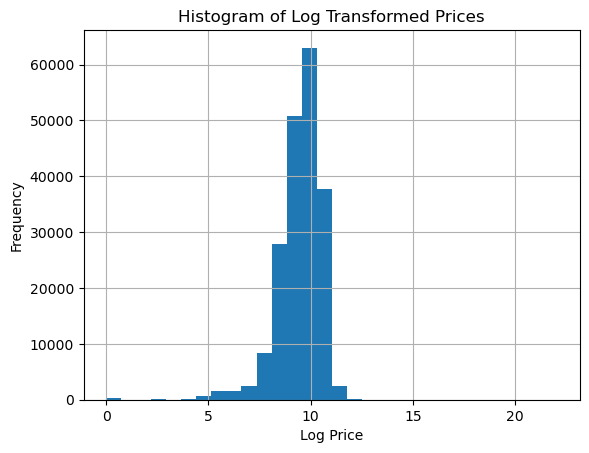

In [89]:
# Distribution of car prices AFTER log transformation:

import matplotlib.pyplot as plt
cars_cleaned['log_price'].hist(bins=30)
plt.title('Histogram of Log Transformed Prices')
plt.xlabel('Log Price')
plt.ylabel('Frequency')
plt.show()

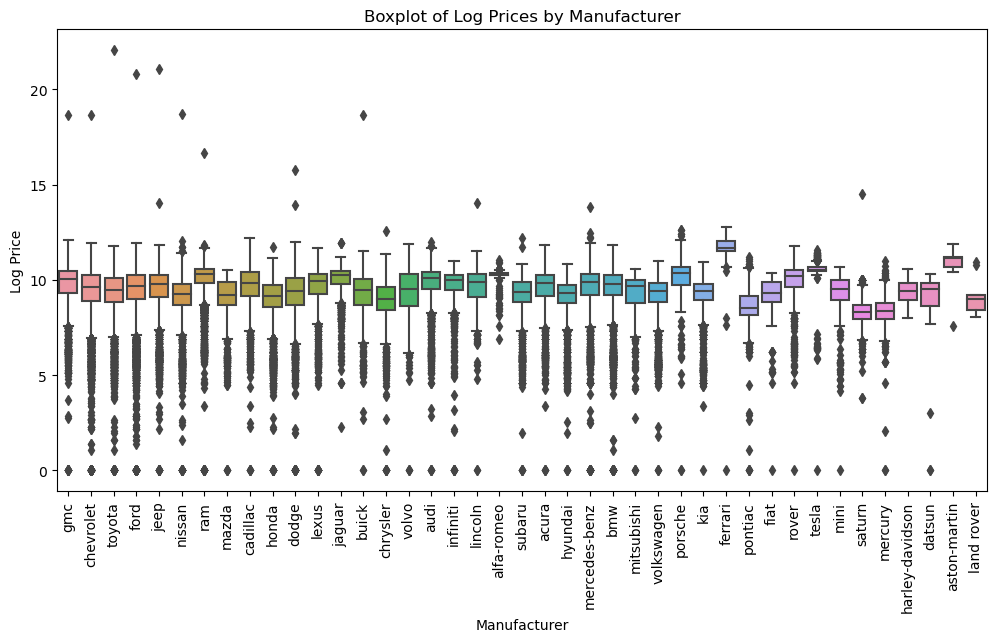

In [90]:
# Variation of prices by car make

import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(x='manufacturer', y='log_price', data=cars_cleaned)
plt.title('Boxplot of Log Prices by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Log Price')
plt.xticks(rotation=90)
plt.show()

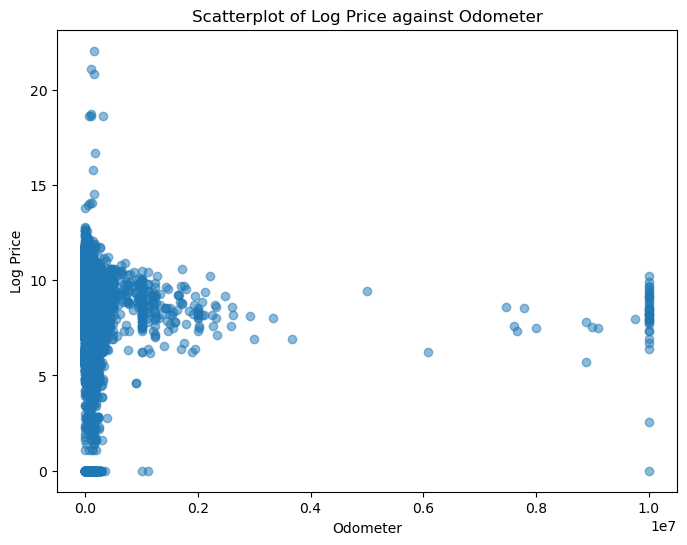

In [91]:
# Scatterplot of 'log_price' against 'odometer' showing the relationship between car prices and mileage.:

plt.figure(figsize=(8, 6))
plt.scatter(cars_cleaned['odometer'], cars_cleaned['log_price'], alpha=0.5)
plt.title('Scatterplot of Log Price against Odometer')
plt.xlabel('Odometer')
plt.ylabel('Log Price')
plt.show()

In [97]:
# Using Target Encoding on 'manufacturer' and 'model' to reduce dimensionality


# Define columns for target encoding
target_enc_cols = ['manufacturer', 'model']

# Define the target encoding method
target_enc = ce.TargetEncoder(cols=target_enc_cols)

# Fit and transform the data using target encoding
cars_cleaned[target_enc_cols] = target_enc.fit_transform(cars_cleaned[target_enc_cols], cars_cleaned['log_price'])

In [98]:
# Encoding to convert the rest of the categorical variables into numerical form.

cars_cleaned = pd.get_dummies(cars_cleaned)

In [99]:
# Print updated DataFrame
print(cars_cleaned)

            year  manufacturer      model  odometer  age  warranty_at_sale  \
id                                                                           
7316814884  2014      9.780316  10.496668   57923.0    9                 0   
7316814758  2010      9.461617   9.746978   71229.0   13                 0   
7316814989  2020      9.461617  10.471968   19160.0    3                 1   
7316743432  2017      9.359582  10.441215   41124.0    6                 0   
7316356412  2013      9.513125   9.432216  128000.0   10                 0   
...          ...           ...        ...       ...  ...               ...   
7301591192  2019      9.155718   9.723246   32226.0    4                 1   
7301591187  2020      9.326684  10.188363   12029.0    3                 1   
7301591147  2020      9.623280  10.458461    4174.0    3                 1   
7301591140  2018      9.675904  10.099888   30112.0    5                 0   
7301591129  2019      9.581678   9.854149   22716.0    4        

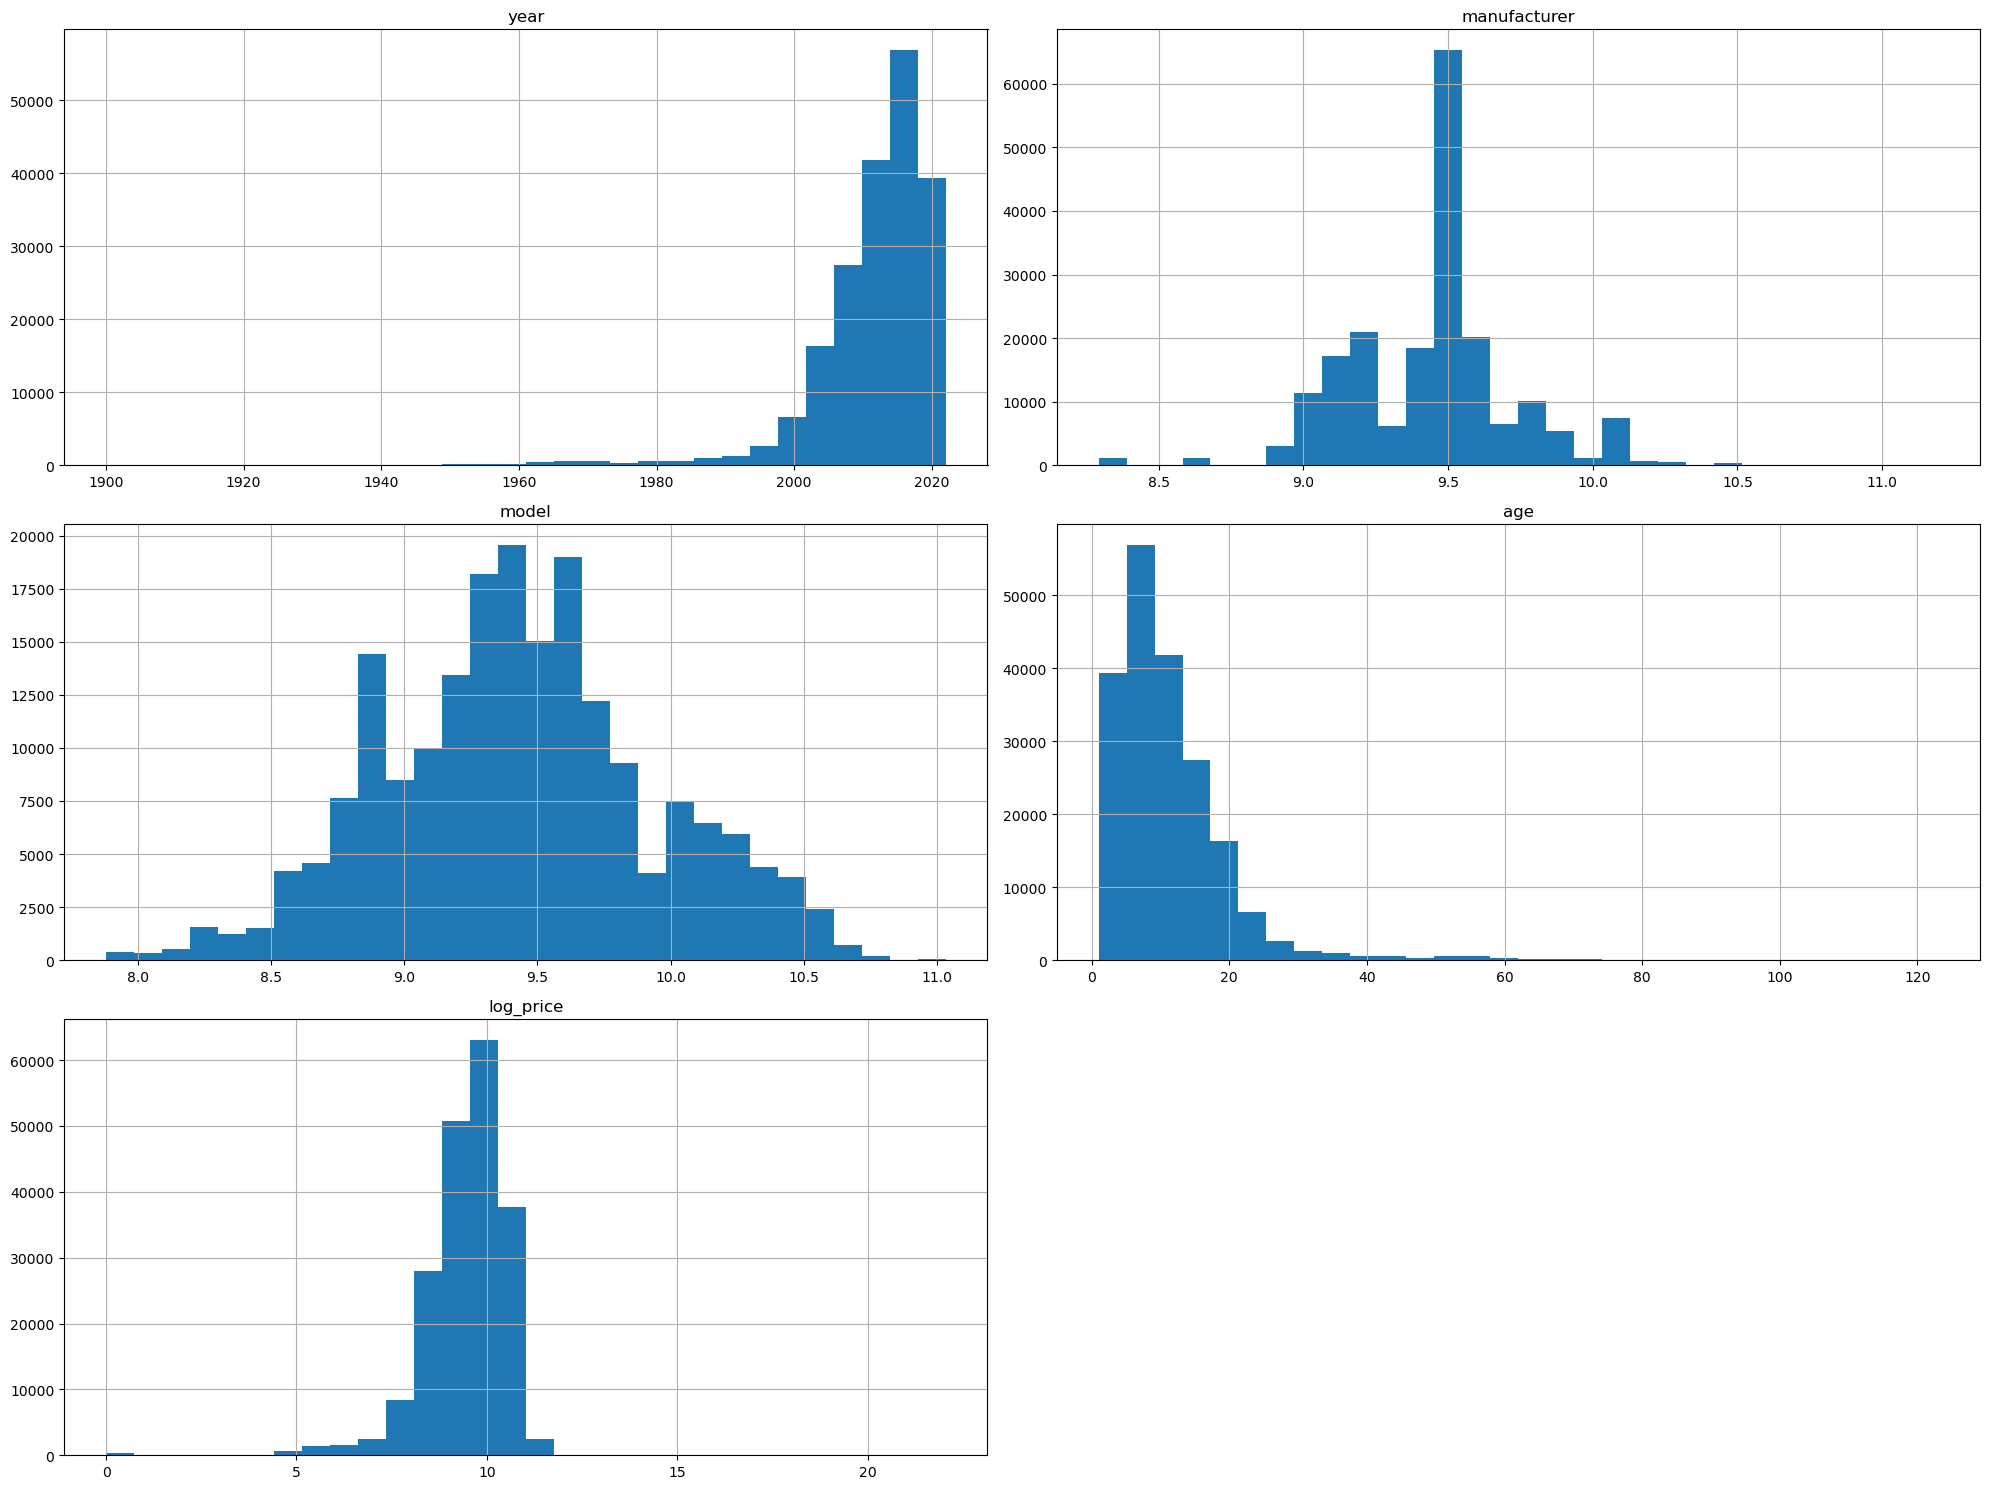

In [101]:
# Creating visualizations to tell the story thus far:

# Select the columns to plot
columns_to_plot = ['year', 'manufacturer', 'model', 'age', 'log_price']

# Plot histograms for the selected columns
cars_cleaned[columns_to_plot].hist(bins=30, figsize=(20,15))
plt.tight_layout()
plt.show()

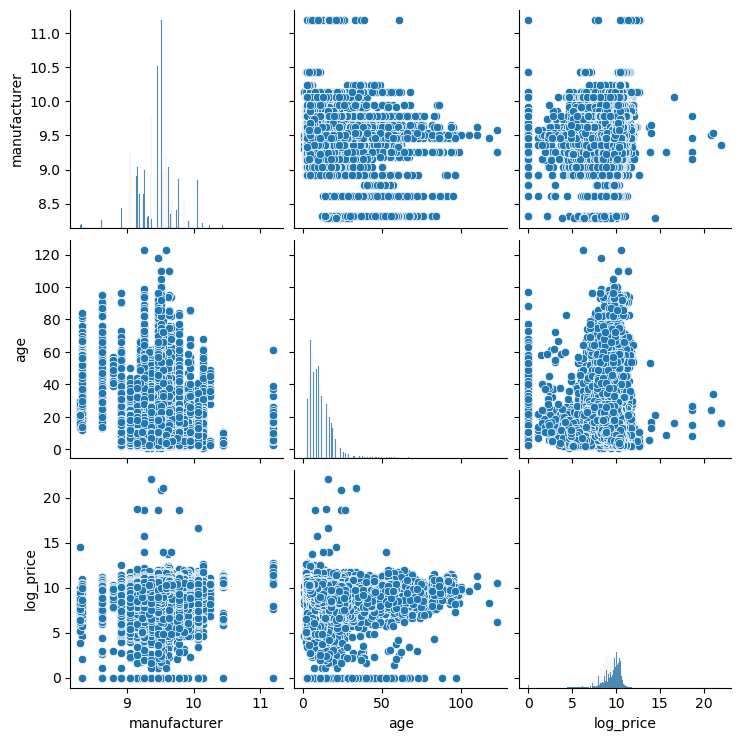

In [103]:
# More visualizations:

# Pairplot - Selecting a subset of columns to plot
columns_to_plot = ['manufacturer', 'age', 'log_price']
sns.pairplot(cars_cleaned[columns_to_plot])

In [107]:
# Let the modeling begin:


# 'log_price' is our target variable
X = cars_cleaned.drop('log_price', axis=1)
y = cars_cleaned['log_price']

# Split our data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the models
linear_model = LinearRegression()
lasso_model = Lasso(alpha=0.1)  # I might want to tune this hyperparameter later
ridge_model = Ridge(alpha=0.1)  # I might want to tune this hyperparameter later

# Train the models
linear_model.fit(X_train, y_train)
lasso_model.fit(X_train, y_train)
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_linear = linear_model.predict(X_test)
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the models
mse_linear = mean_squared_error(y_test, y_pred_linear)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print(f'Linear Regression MSE: {mse_linear}')
print(f'Lasso Regression MSE: {mse_lasso}')
print(f'Ridge Regression MSE: {mse_ridge}')

Linear Regression MSE: 0.75074306541228
Lasso Regression MSE: 0.8195691958582523
Ridge Regression MSE: 0.7507430468772894


/Users/aalladin/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=2.43145e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


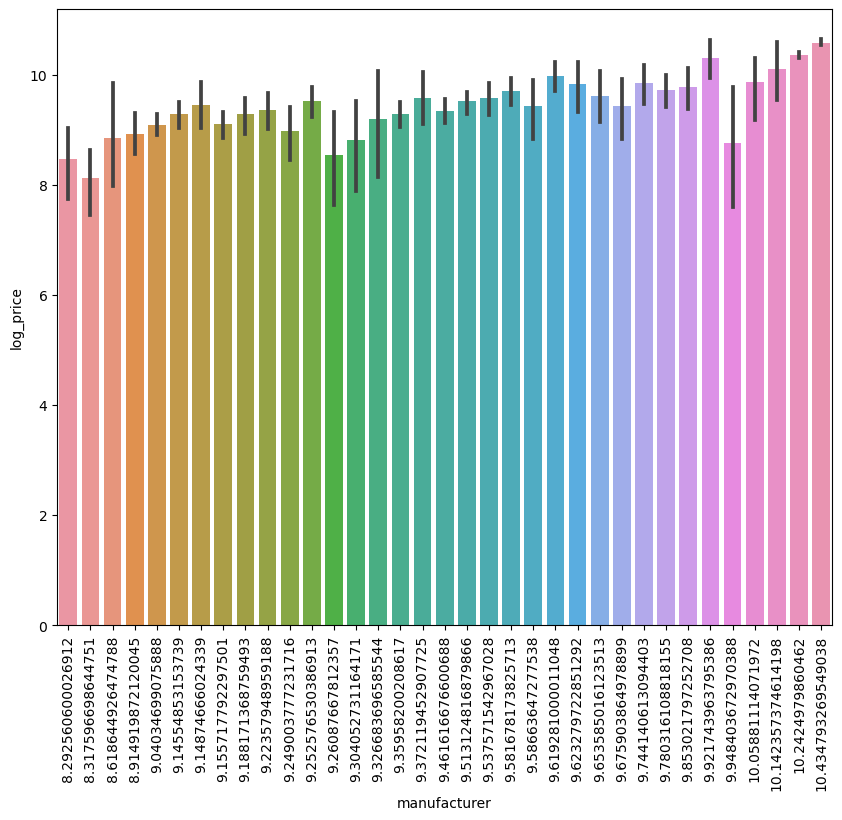

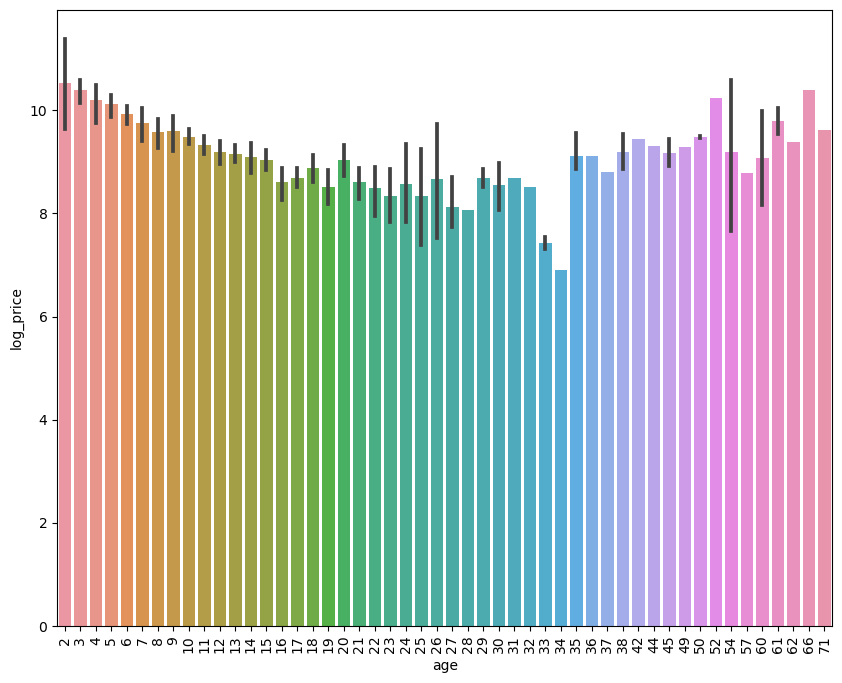

In [119]:
# creating visualization post-modeling our data to validate our findings:

sample_data = cars_cleaned.sample(n=1000, random_state=1)  # Take a random sample of 1000 rows

plt.figure(figsize=(10, 8))
sns.barplot(x='manufacturer', y='log_price', data=sample_data)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()

plt.figure(figsize=(10, 8))
sns.barplot(x='age', y='log_price', data=sample_data)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.show()